# Busbar Thermal Simulation

Adaptation from last year's version in Excel. Would prefer to do it in Python.

### Simulation Outline

See notes on *Accumulator - Splitter Box - V3.0 Busbar Design*

Set Parameters:

* Convective heat transfer coefficient: https://www.engineersedge.com/heat_transfer/convective_heat_transfer_coefficients__13378.htm

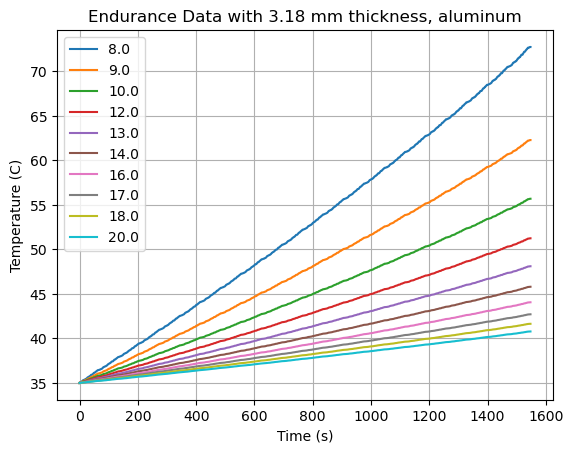

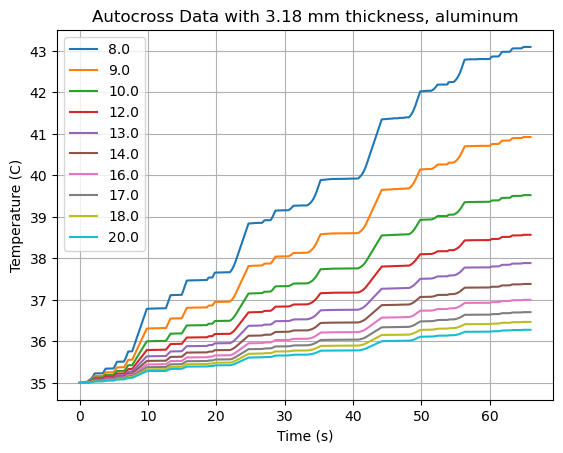

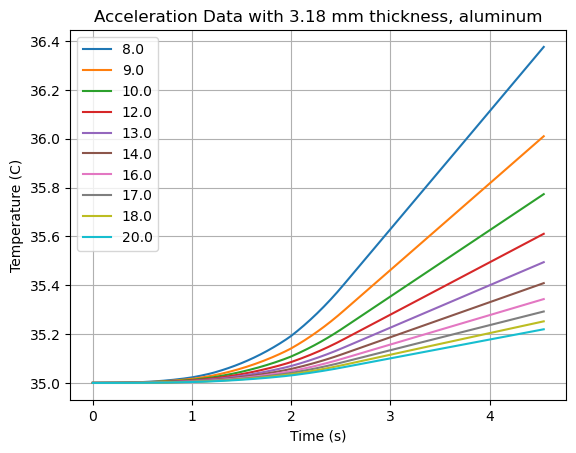

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

####### FILE PATHS
infile_endurance = 'dynamicsCalcs_endurance25.csv'
infile_autocross = 'dynamicsCalcs_auto80.csv'
infile_accel = 'dynamicsCalcs_accel80.csv'

outfile_endurance = "temp_endur25.csv"
outfile_autocross = 'temp_auto80.csv'
outfile_accel = 'temp_accel80.csv'

####### UPLOAD RELEVANT DATA FROM LAP SIM
endur_data = pd.read_csv(infile_endurance)
auto_data = pd.read_csv(infile_autocross)
accel_data = pd.read_csv(infile_accel)

####### SET UP PARAMETERS

### Aluminum
aluminum = {'rho_R': 2.82*10**(-8), 'rho_M': 2710, 'c': 900, 'alpha': 3.8e-3}

### Copper
copper = {'rho_R': 1.77*10**(-8), 'rho_M': 8960, 'c': 385, 'alpha': 3.93e-3}

# Choose material
material = {'aluminum': aluminum, 'copper': copper}

# Thermal Parameters:
T_ambient = 35                      # degrees C - ambient temp
h_free = 0.5                          # W/m2K - assumed convective heat transfer coefficient for free convection of air (minimum chosen)

# Geometry Parameters:
thickness = 3.18 * 10**(-3)         # m - busbar thickness - assumed 1/8"
length = 163.63 * 10**(-3)              # m - longest busbar length (splitter box, negative busbar)

####### VECTORIZED PARAMETER
# mat_choice = 'copper'
mat_choice = 'aluminum'

num = 10
width = np.linspace(8 * 10**(-3), 20 * 10**(-3), num)   # m - width options
A_x = width * thickness                                 # m2 - cross sectional area
A_s = 2 * thickness * length + 2 * width * length       # m2 - accessible surface area (ignore the 2x cross sectional area here)
mass = material[mat_choice]['rho_M'] * A_x * length     # kg - mass options
resistance = material[mat_choice]['rho_R'] * length / A_x # Ohms - resistance options
c = material[mat_choice]['c']                           # J/kgK - specific heat capacity
alpha = material[mat_choice]['alpha']                   # 1/C - Temperature coefficient

###########################################################################################
# Begin Simulation
# 1) Endurance, 2) Acceleration, 3) Autocross

def busbar_temp(dataDict, outfile, race, resistance):
    iterations = len(dataDict)
    busTemp = []                                                        # degrees C - List to record busbar temp
    Q_gen = []                                                          # W - List to record busbar heat generation
    Q_out = []                                                          # W - List to record heat out

    busTemp.append(T_ambient * np.ones(len(mass)))                      # First point required for temperature measurement

    for i in range(0, iterations - 1):
        delta_t = dataDict['t0'][i+1] - dataDict['t0'][i]                           # s - find the delta time
        Q_gen.append(dataDict['Pack Current'][i]**2 * resistance)                   # W - heat generated from busbar
        Q_out.append(h_free * A_s * (busTemp[i] - T_ambient))                       # W - heat out to air - removing the delta t division - because I think it's incorrect units
        # Q_out.append(np.zeros(len(mass)))                                           # W - to test adiabatic case (ie. coated wire)

        busTemp.append((Q_gen[i] - Q_out[i]) * delta_t / (mass * c) + busTemp[i])   # degrees C - next temperature point for busbar

        dR = resistance * alpha * (busTemp[i+1] - busTemp[i])                       # Calculate the new resistance values (delta R)
        resistance = resistance + dR                                                # Ohms - new resistance at new temperature

    # Save to a dataframe and then output to a .csv
    output_temp = pd.DataFrame(busTemp, columns=width)
    output_temp.to_csv(outfile)

    # Plot data
    plt.plot(dataDict['t0'], output_temp)
    plt.title((race + " Data with " + str(thickness * 1000) + " mm thickness, " + mat_choice))
    plt.grid(True)
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (C)")

    # scale width to mm for labels and then truncate
    width_scaled = np.trunc(width * 1000)
    plt.legend(width_scaled)
    plt.savefig(outfile.replace('csv', 'png'))
    plt.show()                                  # clear figure

    return output_temp

endur_temp = busbar_temp(endur_data, outfile_endurance, 'Endurance', resistance)
auto_temp = busbar_temp(auto_data, outfile_autocross, 'Autocross', resistance)
accel_temp = busbar_temp(accel_data, outfile_accel, 'Acceleration', resistance)

### Vehicle Wiring

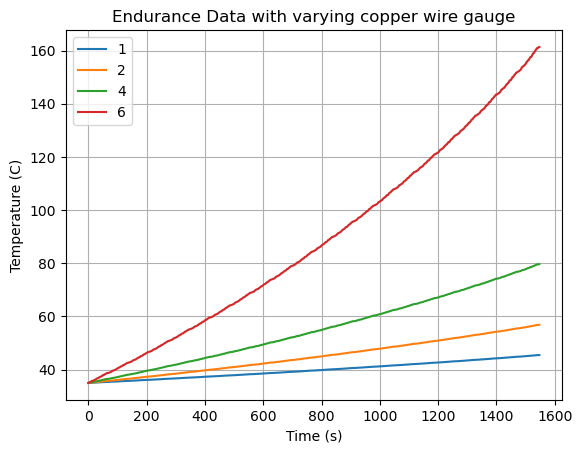

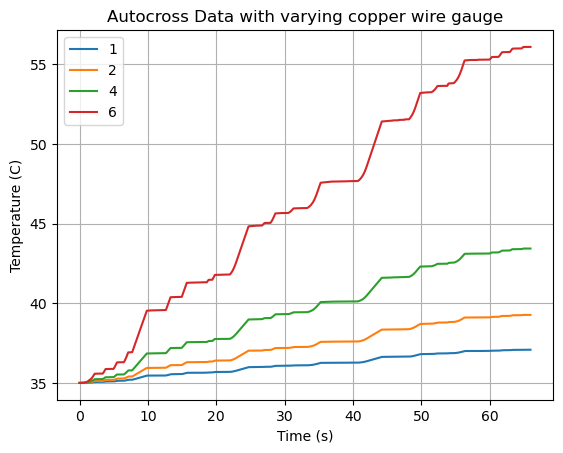

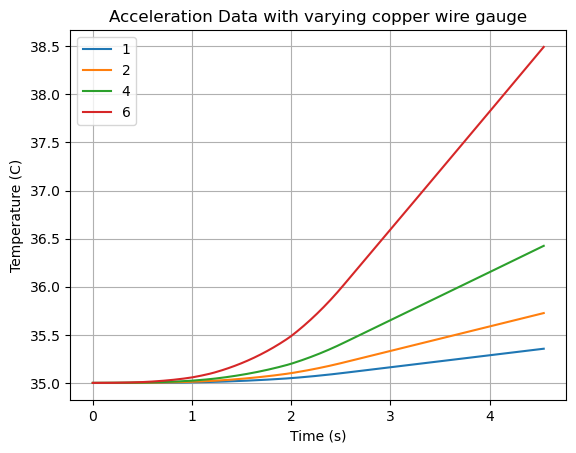

['1', '2', '4', '6']

In [6]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

####### FILE PATHS
infile_endurance = 'dynamicsCalcs_endurance25.csv'
infile_autocross = 'dynamicsCalcs_auto80.csv'
infile_accel = 'dynamicsCalcs_accel80.csv'

outfile_endurance = "temp_endur25_pack.csv"
outfile_autocross = 'temp_auto80_pack.csv'
outfile_accel = 'temp_accel80_pack.csv'

####### UPLOAD RELEVANT DATA FROM LAP SIM
endur_data = pd.read_csv(infile_endurance)
auto_data = pd.read_csv(infile_autocross)
accel_data = pd.read_csv(infile_accel)

####### SET UP PARAMETERS

### Aluminum
aluminum = {'rho_R': 2.82*10**(-8), 'rho_M': 2710, 'c': 900, 'alpha': 3.8e-3}

### Copper
copper = {'rho_R': 1.77*10**(-8), 'rho_M': 8960, 'c': 385, 'alpha': 3.93e-3}

# Choose material
material = {'aluminum': aluminum, 'copper': copper}

# Thermal Parameters:
T_ambient = 35                      # degrees C - ambient temp
h_free = 1                         # W/m2K - assumed convective heat transfer coefficient for free convection of air (minimum chosen)

# Geometry Parameters:
length = 0.16363                        # m - longest busbar length (splitter box, negative busbar)

####### VECTORIZED PARAMETER
# mat_choice = 'copper'
mat_choice = 'aluminum'

pi = math.pi
A_x = np.array([50, 35, 25, 16]) * 10**(-6)             # m2 - for gauges 1, 2, 4, 6
diameter = np.sqrt(A_x * 4 / math.pi)                   # m - diameter
wire_gauges = ["1", "2", "4", "6"]                      # wire gauges
A_s = pi * diameter * length                            # m2 - accessible surface area (ignore the 2x cross sectional area here)
mass = material[mat_choice]['rho_M'] * A_x * length     # kg - mass options
resistance = material[mat_choice]['rho_R'] * length / A_x # Ohms - resistance options
c = material[mat_choice]['c']                           # J/kgK - specific heat capacity
alpha = material[mat_choice]['alpha']                   # 1/C - Temperature coefficient

###########################################################################################
# Begin Simulation
# 1) Endurance, 2) Acceleration, 3) Autocross

def busbar_temp(dataDict, outfile, race, resistance):
    iterations = len(dataDict)
    busTemp = []                                                        # degrees C - List to record busbar temp
    Q_gen = []                                                          # W - List to record busbar heat generation
    Q_out = []                                                          # W - List to record heat out

    busTemp.append(T_ambient * np.ones(len(mass)))                      # First point required for temperature measurement

    for i in range(0, iterations - 1):
        delta_t = dataDict['t0'][i+1] - dataDict['t0'][i]                           # s - find the delta time
        Q_gen.append(dataDict['Pack Current'][i]**2 * resistance)                   # W - heat generated from busbar
        # Q_out.append(h_free * A_s * (busTemp[i] - T_ambient) / delta_t)           # W - heat out to air
        Q_out.append(np.zeros(len(mass)))                                           # W - to test adiabatic case (ie. coated wire)

        busTemp.append((Q_gen[i] - Q_out[i]) * delta_t / (mass * c) + busTemp[i])   # degrees C - next temperature point for busbar

        dR = resistance * alpha * (busTemp[i+1] - busTemp[i])                       # Calculate the new resistance values (delta R)
        resistance = resistance + dR                                                # Ohms - new resistance at new temperature

    # Save to a dataframe and then output to a .csv
    output_temp = pd.DataFrame(busTemp, columns=diameter)
    output_temp.to_csv(outfile)

    # Plot data
    plt.plot(dataDict['t0'], output_temp)
    plt.title((race + " Data with varying copper wire gauge"))
    plt.grid(True)
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (C)")

    # scale diameter to mm for labels and then truncate
    # diameter_scaled = np.trunc(diameter * 1000)
    plt.legend(wire_gauges)
    plt.savefig(outfile.replace('csv', 'png'))
    plt.show()                                  # clear figure

    return output_temp

endur_temp = busbar_temp(endur_data, outfile_endurance, 'Endurance', resistance)
auto_temp = busbar_temp(auto_data, outfile_autocross, 'Autocross', resistance)
accel_temp = busbar_temp(accel_data, outfile_accel, 'Acceleration', resistance)

wire_gauges

In [7]:
import math
import numpy as np
import pandas as pd

# Wire gauge diameters from known areas
A_x = np.array([50, 35, 25, 16])                    # mm2 --> m2 - for gauges 1, 2, 4, 6
diameter = np.sqrt(A_x * 4 / math.pi)               # m - diameter
wire_gauges = ["1", "2", "4", "6"]                  # wire gauges

table = dict({'Areas': A_x, 'Diameters': diameter})

wire_diameter = pd.DataFrame(table, index=wire_gauges)
wire_diameter

,Areas,Diameters
1,50,7.978846
2,35,6.675581
4,25,5.641896
6,16,4.513517


### Read Average Current from Data For ESF Ampacity Specficiations

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

####### FILE PATHS
infile_endurance = 'dynamicsCalcs_endurance25.csv'
infile_autocross = 'dynamicsCalcs_auto80.csv'
infile_accel = 'dynamicsCalcs_accel80.csv'

outfile_endurance = "temp_endur25.csv"
outfile_autocross = 'temp_auto80.csv'
outfile_accel = 'temp_accel80.csv'

####### UPLOAD RELEVANT DATA FROM LAP SIM
endur_data = pd.read_csv(infile_endurance)
auto_data = pd.read_csv(infile_autocross)
accel_data = pd.read_csv(infile_accel)

# Read averages from data
avg_current = np.mean(endur_data['Pack Current'])
max_current = max(endur_data['Pack Current'])
print("Average Current %.3f A" % avg_current)
print("Max Current: %.3f A" % max_current)

max_current = max(accel_data['Pack Current'])
print("Max Accel Current: %.3f A" % max_current)
avg_current = np.mean(accel_data['Pack Current'])
print("Average Accel Current %.3f A" % avg_current)

max_current = max(auto_data['Pack Current'])
print("Max Autocross Current: %.3f A" % max_current)
avg_current = np.mean(auto_data['Pack Current'])
print("Average Auto Current %.3f A" % avg_current)

Average Current 29.506 A
Max Current: 59.941 A
Max Accel Current: 164.180 A
Average Accel Current 145.900 A
Max Autocross Current: 164.565 A
Average Auto Current 58.047 A
